In [1]:
import os
import cv2
import numpy as np
import torch
import random
from PIL import Image, ImageDraw, ImageFont 
import matplotlib.pyplot as plt
import random

from transformers import AutoModelForCausalLM, AutoProcessor

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

# Function to compute IoU and Dice for binary masks.
def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [3]:
local_model_path = "/home/dmatveev/workdir/rosneft_segmentation/models/microsoft_Florence-2-large/"

model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    trust_remote_code=True,
    torch_dtype='auto'
).eval().cuda()

processor = AutoProcessor.from_pretrained(
    local_model_path,
    trust_remote_code=True
)

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
def run_example(image, task_prompt, text_input=None):
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )
    return parsed_answer

In [6]:
dataset_path = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")

all_files = sorted(os.listdir(seismic_dir))
val_files = all_files[:10]

In [7]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

In [8]:
def draw_polygons_on_image(image, prediction, fill_mask=False):
    if '<REGION_TO_SEGMENTATION>' in prediction:
        pred = prediction['<REGION_TO_SEGMENTATION>']
    else:
        pred = prediction

    draw = ImageDraw.Draw(image)
    scale = 1  # adjust if needed

    polygons_list = pred.get('polygons', [])
    labels_list = pred.get('labels', [])

    for poly, label in zip(polygons_list, labels_list):
        # Пример: если label равен "1", выбираем белый, иначе черный.
        if label == '1' or label == 1:
            color = 'white'
            fill_color = 'white' if fill_mask else None
        else:
            color = 'black'
            fill_color = 'black' if fill_mask else None

        for _polygon in poly:
            coords = np.array(_polygon).reshape(-1, 2)
            if len(coords) < 3:
                print('Invalid polygon:', coords)
                continue
            coords = (coords * scale).reshape(-1).tolist()
            if fill_mask:
                draw.polygon(coords, outline=color, fill=fill_color)
            else:
                draw.polygon(coords, outline=color)
            # Отрисовка метки рядом с первой точкой
            draw.text((coords[0] + 8, coords[1] + 2), str(label), fill=color)
    
    return image


In [9]:
seismic_path = os.path.join(seismic_dir, val_files[2])
label_path   = os.path.join(label_dir, val_files[2])

seismic = load_dat_file(seismic_path)
label   = load_dat_file(label_path)

In [10]:
seismic

array([[ 0.82104594,  0.82104594,  0.82104594, ..., -0.36458826,
        -0.48820034, -0.61181235],
       [ 0.82104594,  0.82104594,  0.82104594, ..., -0.36458826,
        -0.48820034, -0.61181235],
       [ 0.82104594,  0.82104594,  0.82104594, ..., -0.36458826,
        -0.48820034, -0.61181235],
       ...,
       [ 0.0705011 ,  0.0705011 ,  0.0705011 , ..., -0.33888698,
        -0.33888698, -0.33888698],
       [ 0.0705011 ,  0.0705011 ,  0.0705011 , ..., -0.33888698,
        -0.33888698, -0.33888698],
       [ 0.0705011 ,  0.0705011 ,  0.0705011 , ..., -0.33888698,
        -0.33888698, -0.33888698]], shape=(224, 224), dtype=float32)

In [11]:
label

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(224, 224), dtype=float32)

In [12]:
if seismic.ndim == 2:
    seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
else:
    seismic_img = seismic

In [13]:
seismic_norm = (seismic_img - seismic_img.min()) / (seismic_img.max() - seismic_img.min())
seismic_uint8 = np.uint8(255 * seismic_norm)
seismic_pil = Image.fromarray(seismic_uint8)

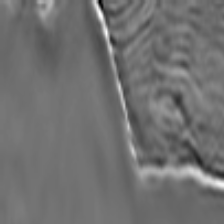

In [14]:
seismic_pil

In [15]:
pos_indices = np.argwhere(label > 0)
if len(pos_indices) > 0:
    ys, xs = pos_indices[:, 0], pos_indices[:, 1]
    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
    h, w = label.shape
    # Quantize coordinates to the range [0, 999]
    qx1 = int(x1 / (w - 1) * 999)
    qy1 = int(y1 / (h - 1) * 999)
    qx2 = int(x2 / (w - 1) * 999)
    qy2 = int(y2 / (h - 1) * 999)
    region_input = f"<loc_{qx1}><loc_{qy1}><loc_{qx2}><loc_{qy2}>"
else:
    region_input = ""  # Fallback if no positive pixels found

In [16]:
region_input

'<loc_0><loc_0><loc_999><loc_999>'

In [27]:
label

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(224, 224), dtype=float32)

In [25]:
pos_indices

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [223, 221],
       [223, 222],
       [223, 223]], shape=(32120, 2))

In [17]:
сolormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

In [18]:
task_prompt = "<REGION_TO_SEGMENTATION>"
# Run the example to obtain the predicted segmentation.
result = run_example(seismic_pil, task_prompt, text_input=region_input)

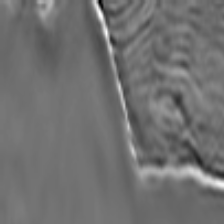

In [19]:
seismic_pil

In [20]:
result

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[0.1120000034570694,
     0.1120000034570694,
     223.21600341796875,
     0.1120000034570694]]],
  'labels': ['']}}

Invalid polygon: [[1.12000003e-01 1.12000003e-01]
 [2.23216003e+02 1.12000003e-01]]


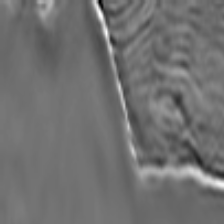

In [22]:
draw_polygons(seismic_pil, result[task_prompt], fill_mask=True)

File: 0.dat, IoU: 0.0000, Dice: 0.0000


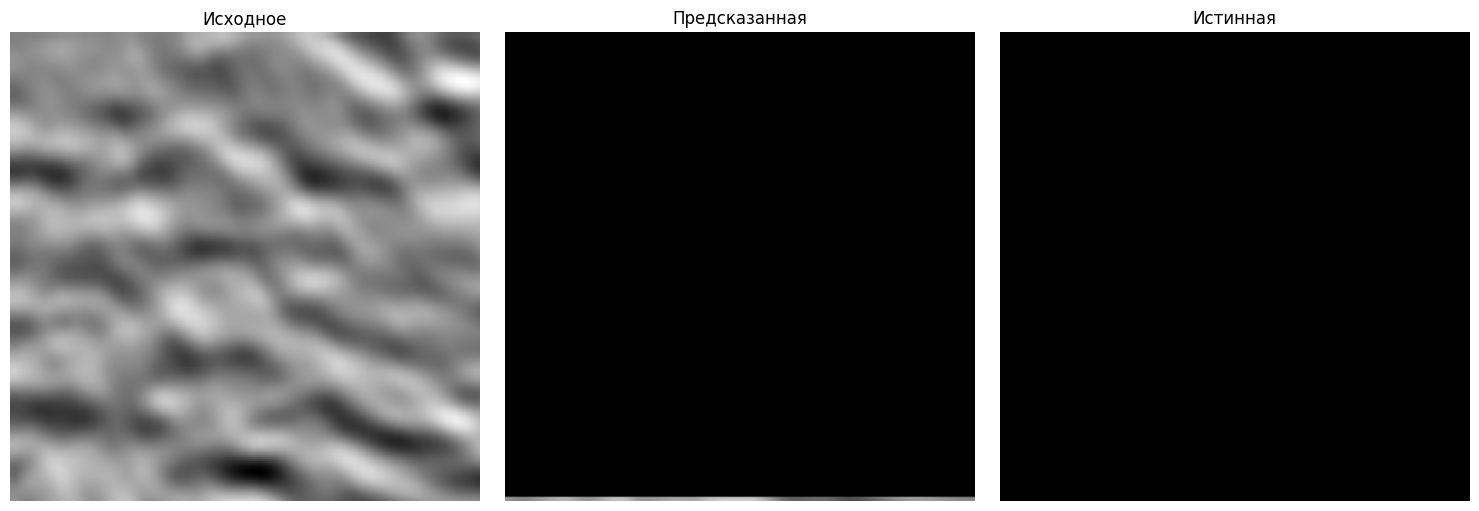

File: 1.dat, IoU: 0.0732, Dice: 0.1364


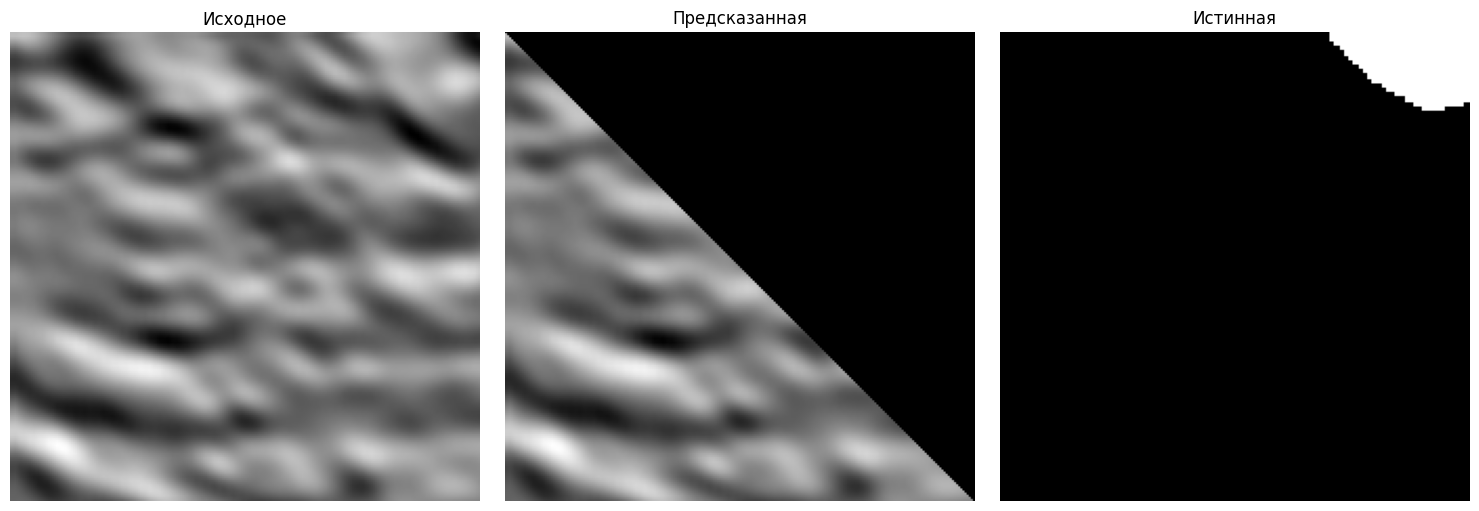

File: 10.dat, IoU: 0.0028, Dice: 0.0055
Invalid polygon: [[1.12000003e-01 1.12000003e-01]
 [2.23216003e+02 1.12000003e-01]]


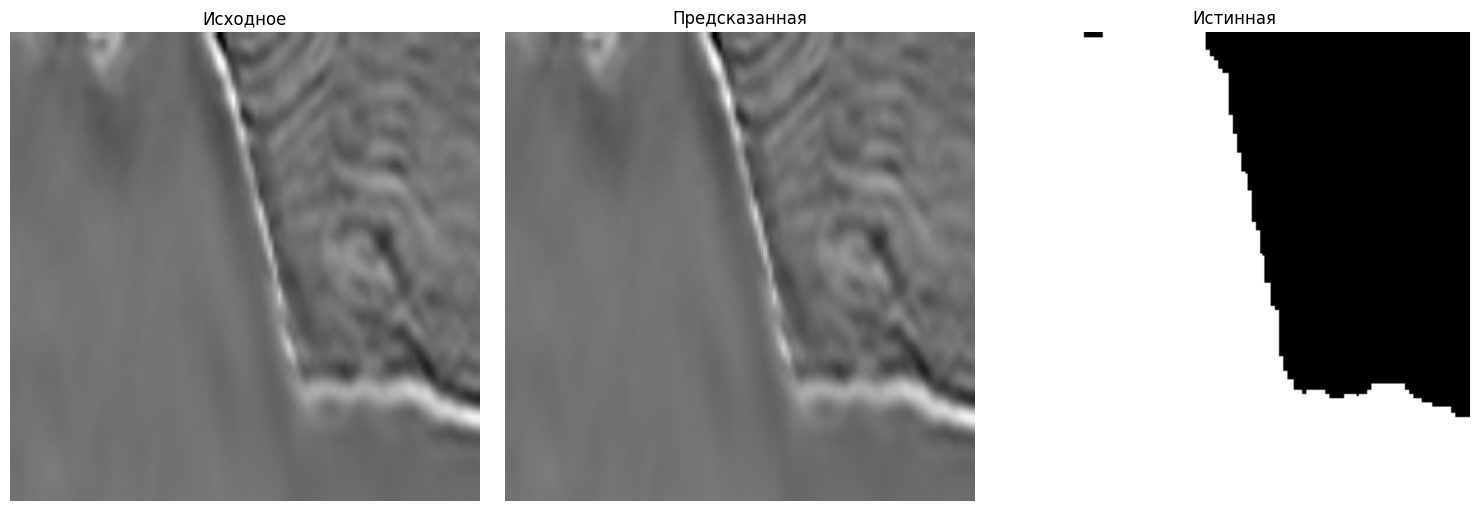

File: 100.dat, IoU: 0.0000, Dice: 0.0000


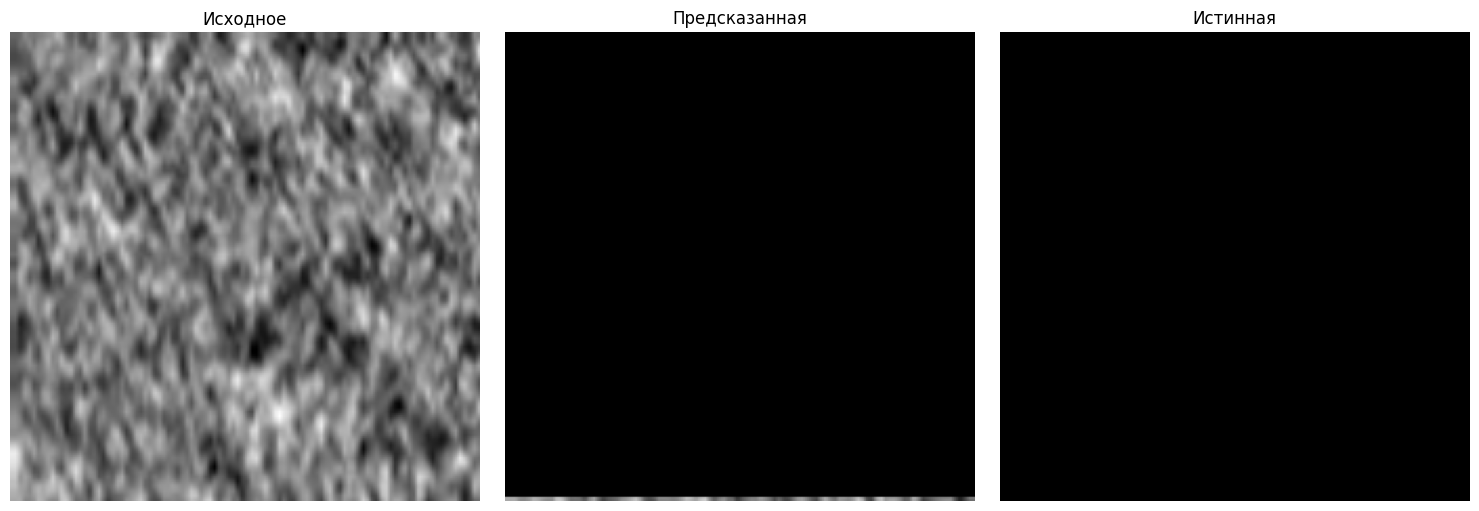

File: 1000.dat, IoU: 0.8980, Dice: 0.9462


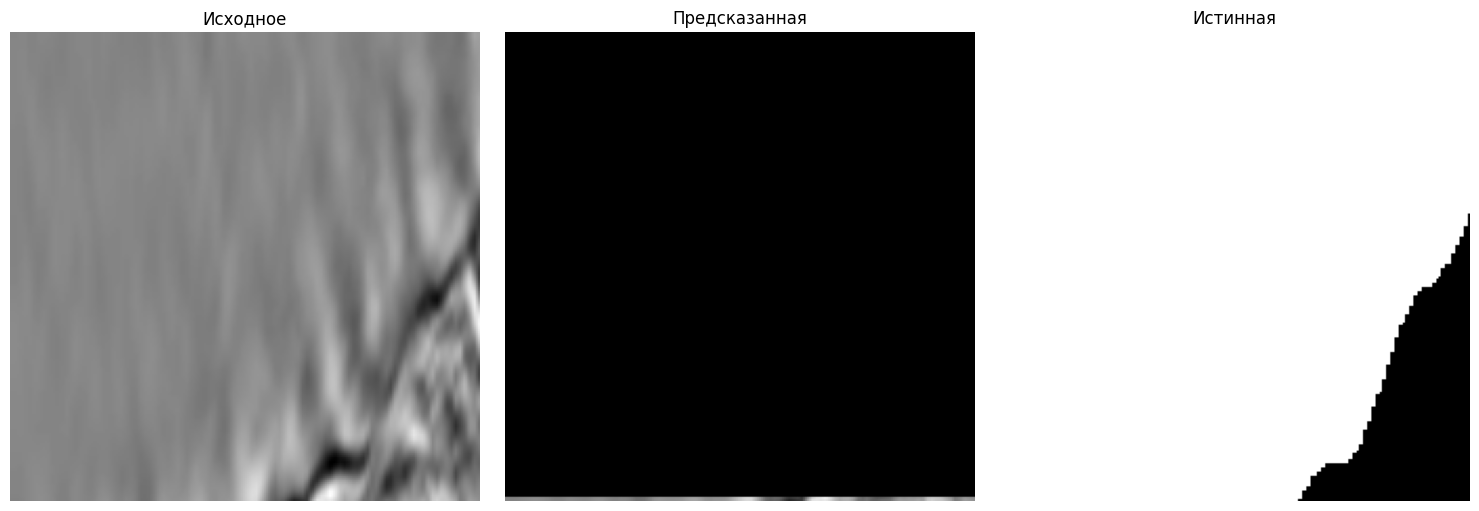

File: 1001.dat, IoU: 0.9129, Dice: 0.9545


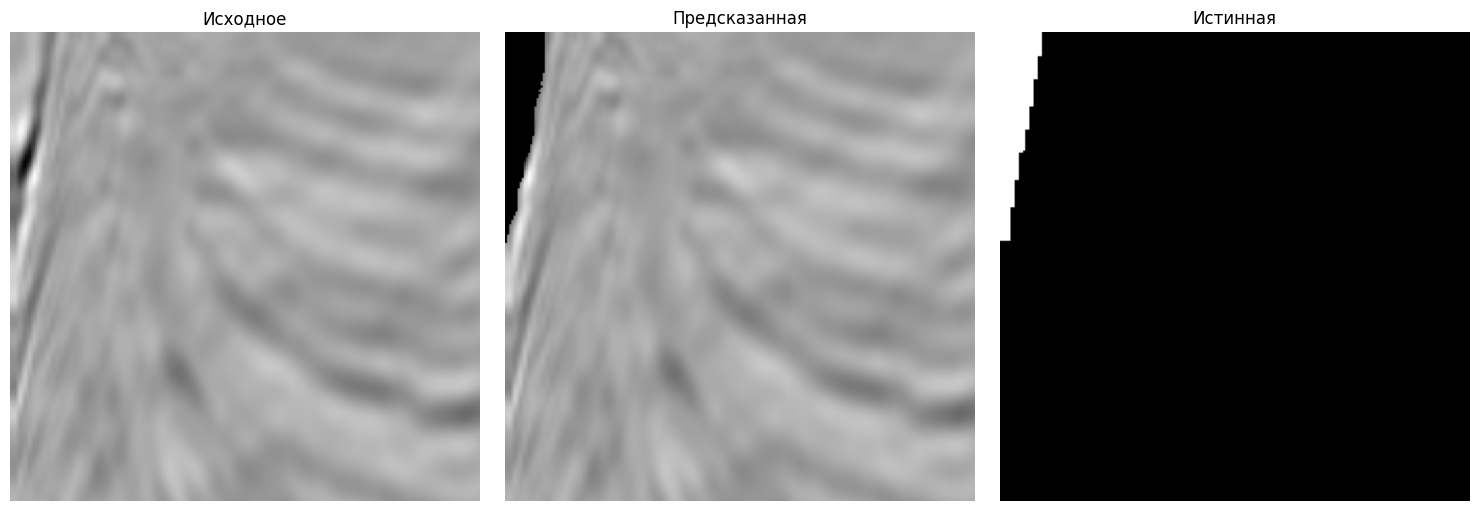

File: 1002.dat, IoU: 0.9312, Dice: 0.9644


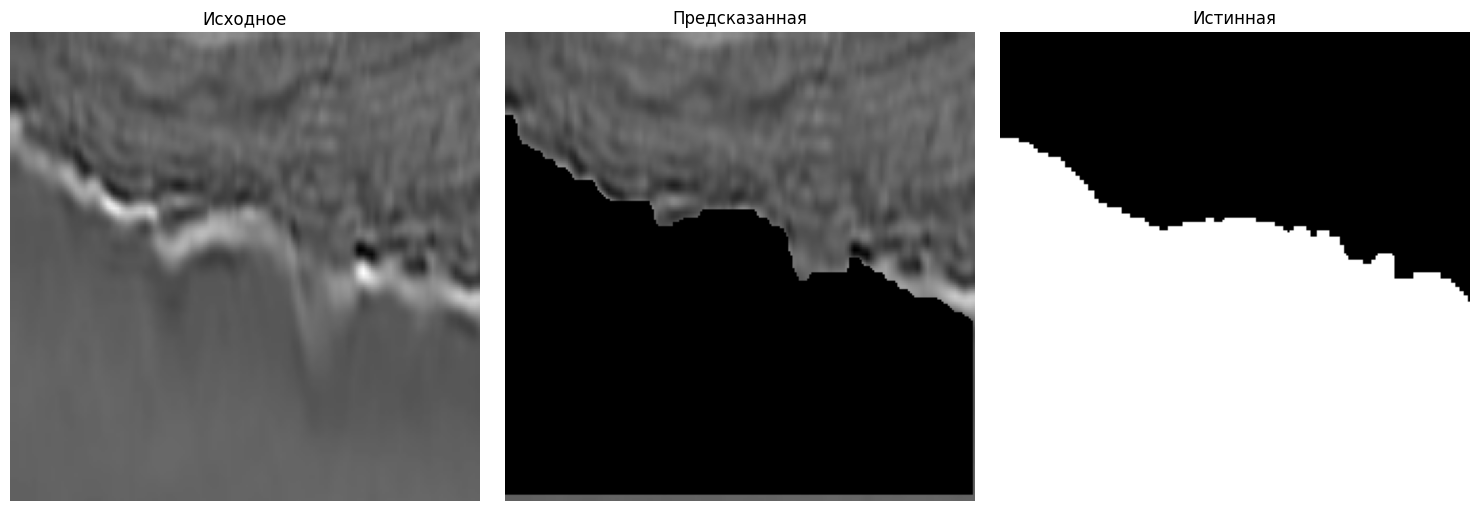

File: 1003.dat, IoU: 0.2998, Dice: 0.4612


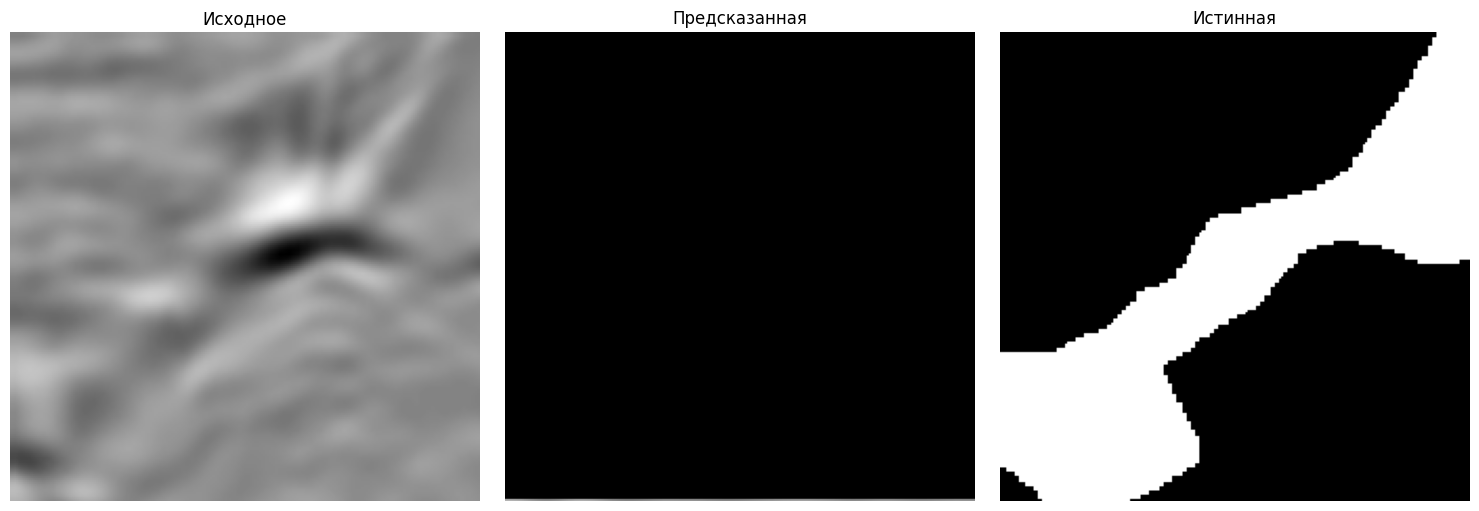

File: 1004.dat, IoU: 0.9743, Dice: 0.9870


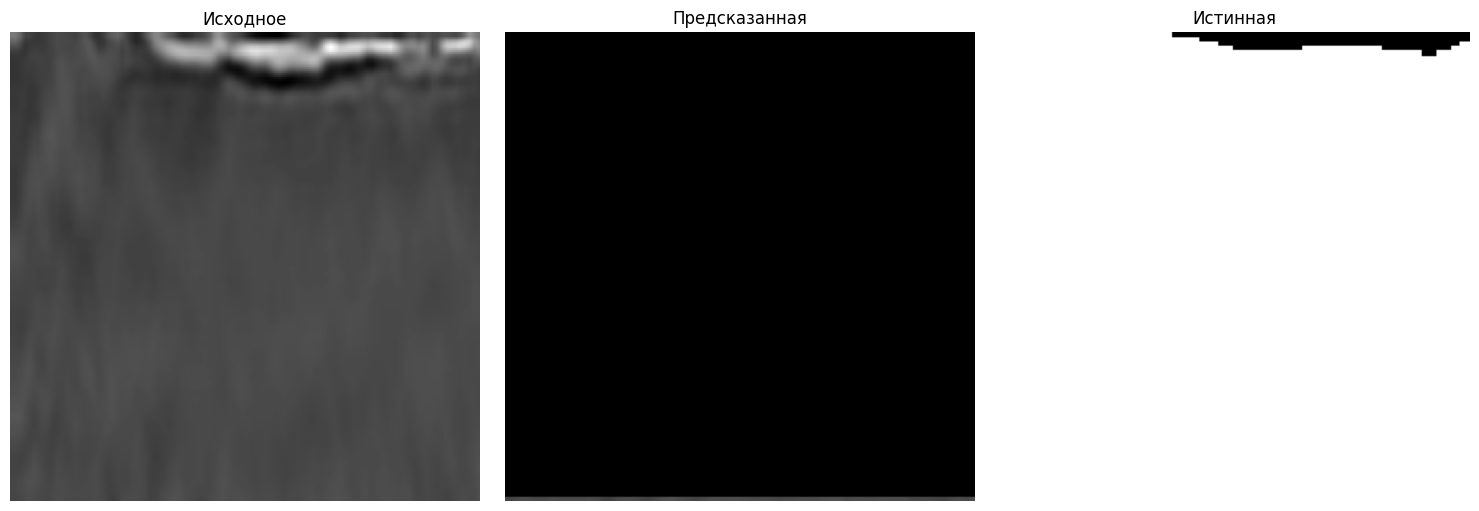

File: 1005.dat, IoU: 0.7281, Dice: 0.8427


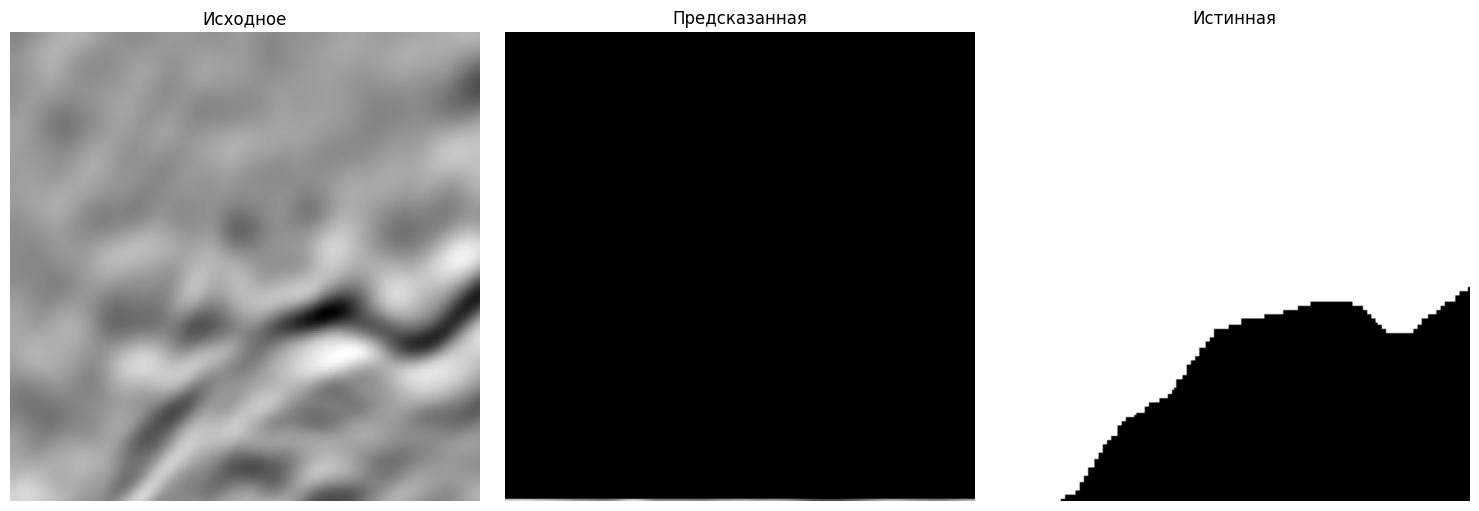

In [36]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Assuming label file name matches seismic file name

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Convert a 2D seismic image to 3 channels if necessary.
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    # Normalize and convert seismic image to a PIL image for visualization.
    seismic_norm = (seismic_img - seismic_img.min()) / (seismic_img.max() - seismic_img.min())
    seismic_uint8 = np.uint8(255 * seismic_norm)
    seismic_pil = Image.fromarray(seismic_uint8)

    # Determine a region to segment by computing a bounding box over positive pixels in the ground truth.
    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        ys, xs = pos_indices[:, 0], pos_indices[:, 1]
        x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
        h, w = label.shape
        # Quantize coordinates to the range [0, 999]
        qx1 = int(x1 / (w - 1) * 999)
        qy1 = int(y1 / (h - 1) * 999)
        qx2 = int(x2 / (w - 1) * 999)
        qy2 = int(y2 / (h - 1) * 999)
        region_input = f"<loc_{qx1}><loc_{qy1}><loc_{qx2}><loc_{qy2}>"
    else:
        region_input = ""  # Fallback if no positive pixels found

    # Prepare the task prompt.
    task_prompt = "<REGION_TO_SEGMENTATION>"
    # Run the example to obtain the predicted segmentation.
    result = run_example(seismic_pil, task_prompt, text_input=region_input)

    # Convert the model output to a binary mask.
    if isinstance(result, Image.Image):
        # If result is an image, convert to binary mask.
        result_np = np.array(result.convert("L"))
        pred_mask = (result_np > 127).astype(np.uint8)
    elif isinstance(result, dict) and '<REGION_TO_SEGMENTATION>' in result:
        # Create an empty mask (background = 0, salt = 1)
        height, width = label.shape
        pred_mask = np.zeros((height, width), dtype=np.uint8)
        pred = result['<REGION_TO_SEGMENTATION>']
        polygons = pred.get('polygons', [])
        # Loop over each polygon candidate and fill it in the mask.
        for poly in polygons:
            for candidate in poly:
                pts = np.array(candidate, dtype=np.float32).reshape(-1, 2)
                pts_int = np.round(pts).astype(np.int32)
                cv2.fillPoly(pred_mask, [pts_int], 1)
    else:
        pred_mask = np.zeros_like(label)

    # Resize predicted mask to match the label's dimensions (if necessary).
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))

    # Compute segmentation metrics.
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Visualization: create a copy of the original image for drawing.
    seismic_draw = seismic_pil.copy()

    # Always create the subplots regardless of the result type.
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    if isinstance(result, dict):
        seismic_draw = draw_polygons_on_image(seismic_draw, result, fill_mask=True)
        pred_viz = np.array(seismic_draw.convert("RGB"), dtype=np.uint8)
    else:
        pred_viz = (pred_mask * 255).astype(np.uint8)

    # Original seismic image (ensure it's in the expected range)
    axes[0].imshow(seismic_uint8, cmap='gray')
    axes[0].set_title("Исходное")
    axes[0].axis('off')

    # Predicted segmentation
    if isinstance(result, dict):
        axes[1].imshow(pred_viz)  # color image from polygons
    else:
        axes[1].imshow(pred_viz, cmap='gray')
    axes[1].set_title("Предсказанная")
    axes[1].axis('off')

    # Ground truth
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title("Истинная")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [34]:
sum(dices)/len(dices)

np.float64(0.5297902557266914)